## Lions & Tigers

The aim of this notebook is to practice deep learning techniques from the fastai mooc

### STEPS
1. Download data from google using `ImageDownloader`
2. Create an `ImageDataBunch`
    - using path, % for validation, size, transformations
    - normalise the data
3. View the data
    - classes and labels as well
4. create a CNN learner object
    - using the data, selected model and metrics
    - add the plot callback
5. fit, save, unfreeze and find a learning rate
    - using `lr_find()`
    - set num_itr?? to linit the number of iterations
6. retrain the model using slice from `lr_find()`
7. save, interpret losses
    - plot top losses

In [1]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

## Download Data

In [2]:
path = Path.cwd()/'data'
path

PosixPath('/Users/devindearaujo/Desktop/fastai/01_practise/lion_tiger/data')

In [ ]:
download_google_images??

In [ ]:
search_terms = {'lion': 'lion', 'tiger':'tiger'}

for animal, name in search_terms.items():
    download_google_images(path, animal, size='>1024*768', n_images=100)
    

In [3]:
#np.random.seed(42)

data = ImageDataBunch.from_folder(path, valid_pct=0.3, 
                                  size=128, 
                                  ds_tfms=get_transforms()).normalize(imagenet_stats)

In [4]:
data.classes, data.c, data.stats

(['lion', 'tiger'], 2, ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

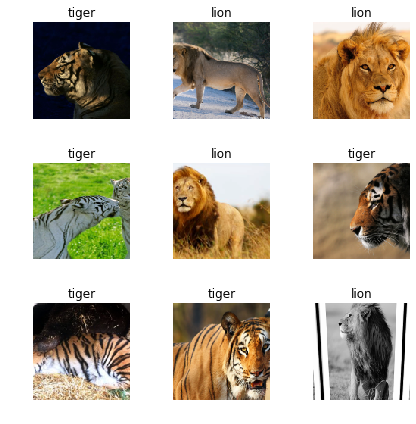

In [5]:
data.show_batch(rows=3, figsize=(6,6))

In [6]:
# check number of items in the training set
pd.value_counts(data.train_ds.y)

tiger    54
lion     54
dtype: int64

In [7]:
# check number of items in the validation set
pd.value_counts(data.valid_ds.y)

tiger    23
lion     22
dtype: int64

## Build a Classifier

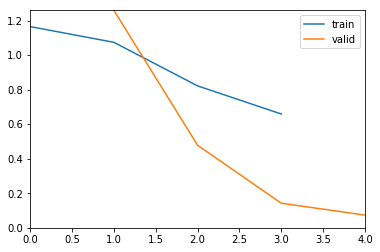

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy,error_rate], callback_fns=ShowGraph)
learn.fit_one_cycle(cyc_len=4)

# you can use this instead of adding the ShowGraph callback
# learn.recorder.plot_losses()

97% Accuracy is very very good for a first try. Even though this is a seemingly easy task, I can't help but be suspicious!

**Things to check**
- If learning rate is too high, validation loss will be astronomically high
    - - **Validation loss is normally underneath 1** 
- If learning rate is too low
    - Error rate gets better very very slowly
    - bump up by 10 or 100 and try again
    - **Training loss will be higher than validation loss**
    - **Training Loss should always be less than validation loss**
        - If this is not the case, you have not fitted enough, learning rate is too low, or epochs too low
- Too many epochs
    - You will be overfitting
    - your model will get very good at recognizing your data set but will not generalize well.

In [12]:
learn.save('cat_stage_1')

learn.unfreeze()

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


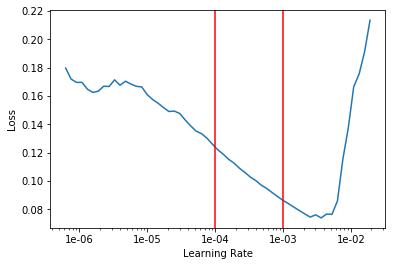

In [14]:
learn.recorder.plot()
plt.axvline(x=1e-4, color='red');
plt.axvline(x=1e-3, color='red');
#plt.axvline(x=3e-5, color='red');
#plt.axvline(x=3e-3, color='red');

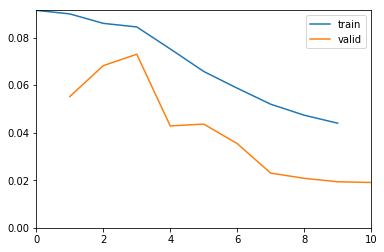

In [15]:
learn.fit_one_cycle(10, max_lr=slice(1e-4,1e-3))

In [16]:
learn.save('cats_stage_2')

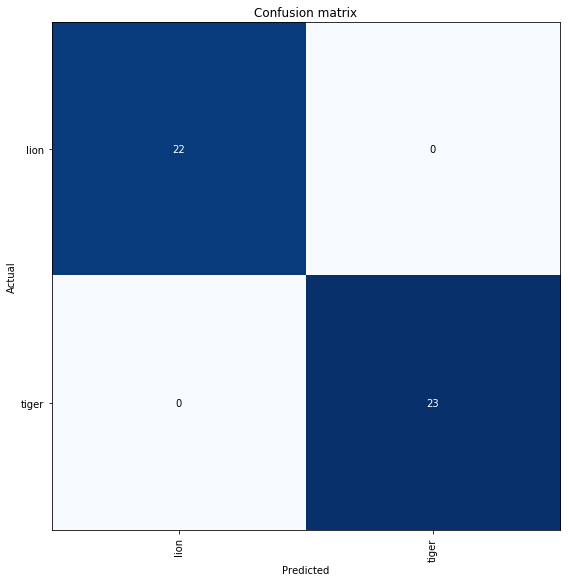

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

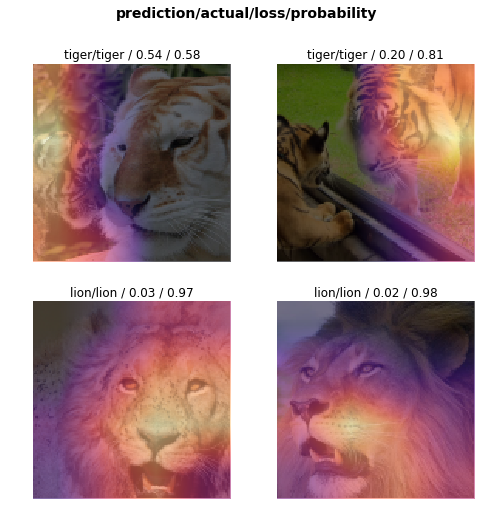

In [18]:
interp.plot_top_losses(k=4, figsize=(8,8))

## Putting the model in Prod

### Steps
- export learner
- create route


In [19]:
learn.export()

In [20]:
defaults.device = torch.device('cpu')

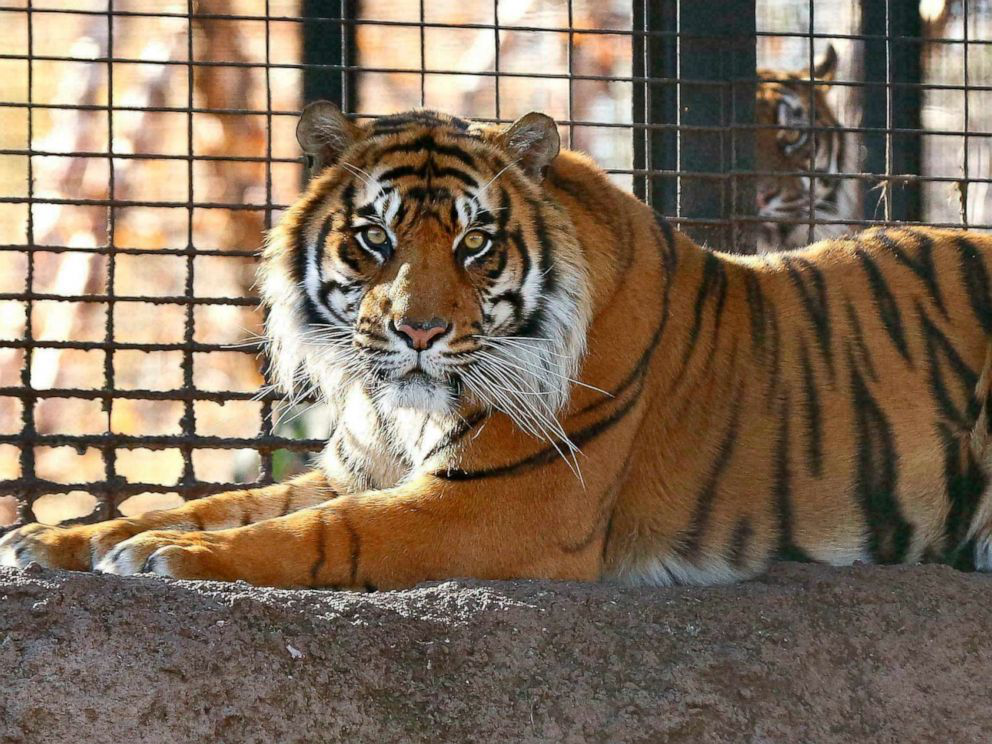

In [21]:
img = open_image(path/'tiger'/'00000070.jpg')
img

In [22]:
learn = load_learner(path)

In [23]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category tiger

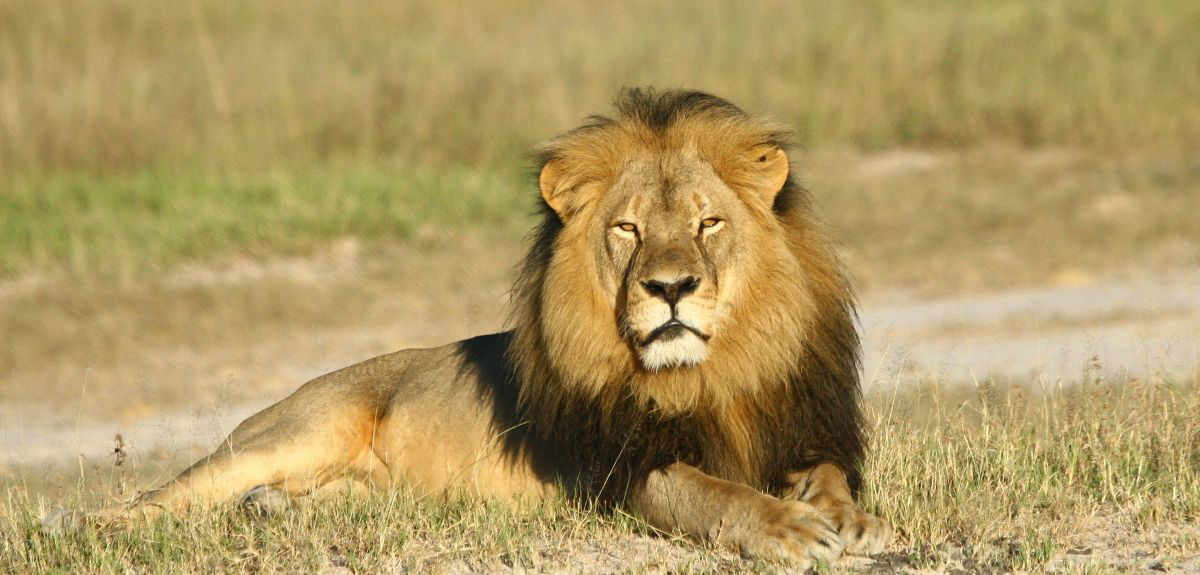

In [24]:
img_2 = open_image(path/'lion'/'00000071.jpg')
img_2

In [25]:
pred_class,pred_idx,outputs = learn.predict(img_2)
pred_class

Category lion

In [26]:
learn.predict(img_2)

(Category lion, tensor(0), tensor([9.9943e-01, 5.6756e-04]))

In [27]:
# loop through a few images and test
images = ['tiger/00000070.jpg','tiger/00000018.jpg','tiger/00000032.jpg','tiger/00000045.jpg','tiger/00000027.jpg','tiger/00000044.jpg',
         'lion/00000012.jpg','lion/00000023.jpg','lion/00000054.jpg','lion/00000070.jpg','lion/00000046.jpg','lion/00000089.jpg']


for image in images:
    img = open_image(path/image)
    pred_class,pred_idx,outputs = learn.predict(img)
    print(pred_class,image)
    

tiger tiger/00000070.jpg
tiger tiger/00000018.jpg
tiger tiger/00000032.jpg
tiger tiger/00000045.jpg
tiger tiger/00000027.jpg
tiger tiger/00000044.jpg
lion lion/00000012.jpg
lion lion/00000023.jpg
lion lion/00000054.jpg
lion lion/00000070.jpg
lion lion/00000046.jpg
lion lion/00000089.jpg


# Things that can go wrong

## 1. Learning rate (LR) too high
- If the learning rate is too high (say 0.5, it's normally 0.003), then the validation loss will be astronomically high. 
- **Validation loss is normally underneath 1** 
- To fix this, you need to create your neural net again and start from scratch

## 2. Learning rate (LR) too low
- The error rate will get better but very very slowy
- **The other thing you will see if your learning rate is too small is that your training loss will be higher than your validation loss**
- That means you have not fitted enough. 
    - So learning rate is too low or there are too few epochs

## 3. Too many epochs
- Creates overfitting
- If you train for too long, your model will not generalise well
- It is hard to overfit
- You are overfitting if your error rate improves for a while and then starts to worsen again
- 
    
## Important
- You never want a model where your training loss is higher than your validation loss. That means you have not fitted enough. That means your learning rate is too low or your number of epochs is too low.
- solution: Train longer or with higher learning rate.
- **Training loss should always be lower than validation loss**
- You are not overfitting if your error rate is continually imporving